# **Import Libraries**

In [1]:
!pip install pandas numpy geopandas scipy rasterio matplotlib xarray cartopy contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 51.4 MB/s eta 0:00:00


In [2]:
import calendar
import contextily as ctx
import glob
import joblib
import os
import time
import traceback
import xml.etree.ElementTree as ET
from datetime import datetime
import geopandas as gpd
import matplotlib.animation as animation
import matplotlib.colors as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import rasterio
import seaborn as sns
import xarray as xr
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.patches import Patch
from pyproj import Transformer
from rasterio.features import geometry_mask
from rasterio.mask import mask
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from scipy import interpolate
from scipy.ndimage import binary_dilation, gaussian_filter
from scipy.optimize import minimize
from scipy.stats import pearsonr, spearmanr
from shapely.geometry import Point, Polygon, box
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier,RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, LeaveOneOut, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# **Environmental Impact**

More at the end of the notebook

In [3]:
class EnvironmentalImpactCalculator:

    def __init__(self):
        self.start_time = None
        self.processing_log = []

        # Energy consumption estimates (kWh per operation)
        self.energy_factors = {
            'satellite_download_gb': 0.05,  # kWh per GB downloaded
            'satellite_processing_gb': 0.1,  # kWh per GB processed
            'ml_training_simple': 0.01,     # kWh per model training
            'ml_training_cv': 0.05,         # kWh per cross-validation
            'data_storage_gb_year': 0.002,  # kWh per GB stored annually
            'gpu_hour': 0.3,                # kWh per GPU hour (if using GPU)
            'cpu_hour': 0.1                 # kWh per CPU hour
        }

        # Carbon intensity factors (kg CO2 per kWh) - global average
        self.carbon_intensity = {
            'global_average': 0.5,   # kg CO2/kWh
            'coal_heavy': 0.9,       # kg CO2/kWh
            'renewable_heavy': 0.1,  # kg CO2/kWh
            'cloud_computing': 0.35  # kg CO2/kWh
        }

    def start_tracking(self, operation_name):
        self.start_time = time.time()
        self.start_cpu_percent = psutil.cpu_percent(interval=1)
        print(f" Started tracking: {operation_name}")

    def end_tracking(self, operation_name, data_size_gb=None, operation_type='processing'):
        duration_hours = (time.time() - self.start_time) / 3600
        avg_cpu_percent = (self.start_cpu_percent + psutil.cpu_percent()) / 2

        # Estimate energy consumption
        if operation_type == 'download' and data_size_gb:
            energy_kwh = data_size_gb * self.energy_factors['satellite_download_gb']
        elif operation_type == 'processing' and data_size_gb:
            energy_kwh = data_size_gb * self.energy_factors['satellite_processing_gb']
        elif operation_type == 'ml_training':
            energy_kwh = self.energy_factors['ml_training_simple']
        elif operation_type == 'ml_cv':
            energy_kwh = self.energy_factors['ml_training_cv']
        else:
            energy_kwh = duration_hours * self.energy_factors['cpu_hour'] * (avg_cpu_percent / 100)

        self.processing_log.append({
            'operation': operation_name,
            'duration_hours': duration_hours,
            'data_size_gb': data_size_gb or 0,
            'energy_kwh': energy_kwh,
            'timestamp': datetime.now()
        })

        print(f" Completed: {operation_name}")
        print(f" Duration: {duration_hours:.3f} hours")
        print(f" Estimated energy: {energy_kwh:.4f} kWh")

        self.start_time = None

    def print_environmental_report(self):
        if not self.processing_log:
            print("No operations tracked yet!")
            return

        df = pd.DataFrame(self.processing_log)
        total_energy = df['energy_kwh'].sum()
        total_co2 = total_energy * self.carbon_intensity['cloud_computing']

        print(f"Environmental Impact Study")
        print("=" * 50)
        print(f"Total Operations: {len(df)}")
        print(f"Total Energy: {total_energy:.4f} kWh")
        print(f"Total CO₂: {total_co2:.4f} kg")
        print(f"Equivalent to driving: {total_co2 * 5:.1f} km")

        print(f" BREAKDOWN:")
        for _, row in df.iterrows():
            co2 = row['energy_kwh'] * self.carbon_intensity['cloud_computing']
            print(f"{row['operation']:20} | {row['energy_kwh']:.4f} kWh | {co2:.4f} kg CO₂")

In [4]:
env_calculator = EnvironmentalImpactCalculator()
env_calculator.start_tracking("Complete Groundwater Analysis")

 Started tracking: Complete Groundwater Analysis


# **Setting Up**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [7]:
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    return directory

In [8]:
def log_processing_step(step_name, additional_info=None):
    print(f"\n{'-'*80}")
    print(f"PROCESSING STEP: {step_name}")
    if additional_info:
        print(f"{additional_info}")
    print(f"{'-'*80}")

In [9]:
sentinel1_folder = "/content/drive/MyDrive/Colab Notebooks/AI4EO/Coursework/Groundwater Brazil/Datasets/sentinel_1_data"
well_data_path = '/content/RIMAS - Alter do Chao 2019.csv'
grace_folder = '/content/drive/MyDrive/Colab Notebooks/AI4EO/Coursework/Groundwater Brazil/Datasets/GRACE/2019'
gldas_folder = '/content/drive/MyDrive/Colab Notebooks/AI4EO/Coursework/Groundwater Brazil/Datasets/GLDAS/2019'
output_folder = "/content/drive/MyDrive/Colab Notebooks/AI4EO/Coursework/Groundwater Brazil/Results/Analysis"

year = 2019
buffer_degrees = 0.02

wet_season_months = [11, 12, 1, 2, 3, 4]  # Nov-Apr
dry_season_months = [5, 6, 7, 8, 9, 10]  # May-Oct

# **Create Region of Interest**

In [10]:
def create_roi():

    for month in range(1, 13):
        year_month_str = f"{year}{month:02d}"
        month_folder = os.path.join(sentinel1_folder, year_month_str)

        if not os.path.exists(month_folder):
            continue

        try:
            folder_contents = os.listdir(month_folder)
            safe_folders = [item for item in folder_contents if item.endswith('.SAFE')]

            if safe_folders:
                safe_folder = os.path.join(month_folder, safe_folders[0])
                annotation_folder = os.path.join(safe_folder, 'annotation')

                if os.path.exists(annotation_folder):
                    xml_files = [f for f in os.listdir(annotation_folder) if f.endswith('.xml')]

                    if xml_files:
                        tree = ET.parse(os.path.join(annotation_folder, xml_files[0]))
                        root = tree.getroot()

                        lats, lons = [], []
                        for point in root.findall('.//{*}geolocationGridPoint'):
                            lat_elem = point.find('.//{*}latitude')
                            lon_elem = point.find('.//{*}longitude')
                            if lat_elem is not None and lon_elem is not None:
                                lats.append(float(lat_elem.text))
                                lons.append(float(lon_elem.text))

                        if lats and lons:
                            min_lon = min(lons) - buffer_degrees
                            max_lon = max(lons) + buffer_degrees
                            min_lat = min(lats) - buffer_degrees
                            max_lat = max(lats) + buffer_degrees

                            bounds = (min_lon, min_lat, max_lon, max_lat)

                            print(f" Study area defined from {calendar.month_name[month]} data")
                            print(f" Bounds: {bounds}")
                            print(f" Size: {((max_lon-min_lon)*111):.1f} x {((max_lat-min_lat)*111):.1f} km")

                            return bounds
        except Exception as e:
            continue
    return (min_lon, min_lat, max_lon, max_lat)

In [11]:
roi_bounds = create_roi()

 Study area defined from January data
 Bounds: (-60.79301306799832, -3.742732482304937, -58.182940382825784, -1.701554491878766)
 Size: 289.7 x 226.6 km


In [12]:
def visualise_roi(roi_bounds, output_folder="output_maps", zoom_factor=1.0):

    minx, miny, maxx, maxy = roi_bounds
    roi_geometry = box(minx, miny, maxx, maxy)
    roi_gdf = gpd.GeoDataFrame([1], geometry=[roi_geometry], crs="EPSG:4326")

    fig, ax = plt.subplots(figsize=(12, 10))

    roi_gdf.boundary.plot(ax=ax, color='red', linewidth=3, label='Region of Interest')

    current_width = maxx - minx
    current_height = maxy - miny

    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    min_display_width = 10
    min_display_height = 10

    display_width = max(current_width * (1 / zoom_factor), min_display_width)
    display_height = max(current_height * (1 / zoom_factor), min_display_height)

    ax.set_xlim(center_x - display_width / 2,
                center_x + display_width / 2)
    ax.set_ylim(center_y - display_height / 2,
                center_y + display_height / 2)

    ctx.add_basemap(ax,crs=roi_gdf.crs,source=ctx.providers.Esri.WorldImagery,zoom='auto')

    ax.set_title('Region of Interest', fontsize=14)
    ax.legend()
    ax.grid(False)
    ax.set_aspect('equal')

    plt.tight_layout()

    os.makedirs(output_folder, exist_ok=True)
    roi_plot_path = os.path.join(output_folder, f'roi_coverage_basemap_zoom_{zoom_factor:.2f}.png')
    plt.savefig(roi_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

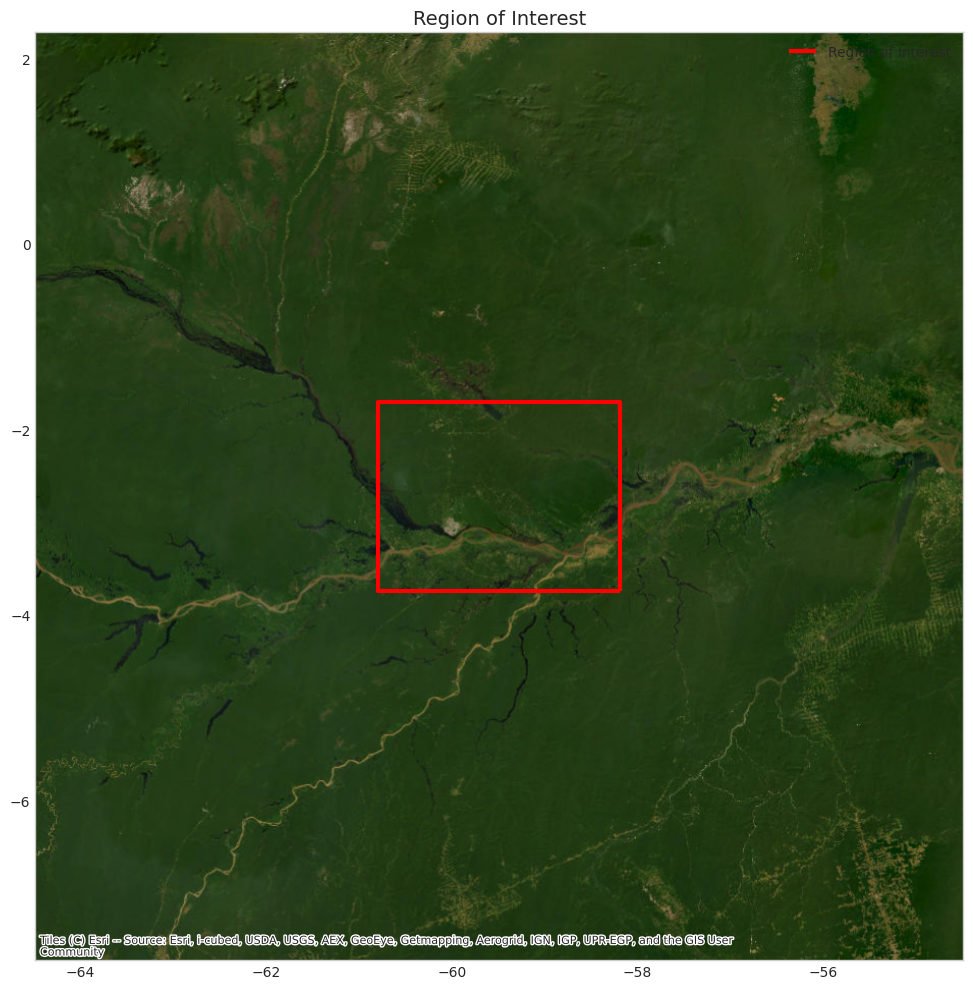

In [13]:
visualise_roi(roi_bounds, output_folder=output_folder, zoom_factor=5)

# **Pre-processing and Initial Analysis**

**Well Data**

In [14]:
def analyse_wells(roi_bounds, year=2019, wet_season_months=[11, 12, 1, 2, 3, 4], dry_season_months=[5, 6, 7, 8, 9, 10]):

    wells_df = pd.read_csv(well_data_path)
    wells_df['time'] = pd.to_datetime(wells_df['time'])
    wells_df = wells_df[wells_df['time'].dt.year == year].copy()

    minx, miny, maxx, maxy = roi_bounds
    roi_wells = wells_df[
        (wells_df['lon'] >= minx) & (wells_df['lon'] <= maxx) &
        (wells_df['lat'] >= miny) & (wells_df['lat'] <= maxy)
    ].copy()

    print(f"Wells in study area: {roi_wells['id'].nunique()}")
    print(f"Total measurements in ROI for {year}: {len(roi_wells)}")

    well_month_counts = roi_wells.groupby('id')['time'].apply(lambda x: x.dt.month.nunique())

    wells_with_12_months = well_month_counts[well_month_counts == 12].index.tolist()

    print(f"Wells with data for all 12 months in {year} within ROI: {len(wells_with_12_months)}")
    if len(wells_with_12_months) > 0:
        print(f"IDs: {wells_with_12_months}")
    else:
        print("No wells found with data for all 12 months in the ROI.")

    filtered_wells = roi_wells[roi_wells['id'].isin(wells_with_12_months)].copy()

    monthly_well_data = []

    for month in range(1, 13):
        month_data = filtered_wells[filtered_wells['time'].dt.month == month]
        if len(month_data) > 0:
            monthly_well_data.append({
                'month': month,
                'month_name': calendar.month_name[month],
                'season': 'wet' if month in wet_season_months else 'dry',
                'mean_storage_change': month_data['var_month'].mean(),
                'std_storage_change': month_data['var_month'].std(),
                'n_wells': len(month_data),
                'n_unique_wells': month_data['id'].nunique()
            })

    monthly_wells_df = pd.DataFrame(monthly_well_data)
    create_well_plot(monthly_wells_df)

    return monthly_wells_df

In [15]:
def create_well_plot(monthly_wells_df):

    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

    colors = ['lightblue' if row['season'] == 'wet' else 'orange' for _, row in monthly_wells_df.iterrows()]

    bars = ax1.bar(monthly_wells_df['month_name'], monthly_wells_df['mean_storage_change'],
                    capsize=5, color=colors, alpha=0.7)

    ax1.set_title('Average Well Groundwater Level Change (Month-on-Month)', fontweight='bold')
    ax1.set_ylabel('Groundwater Level Change from previous month (cm)')
    ax1.set_xlabel('Month')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    for i, (_, row) in enumerate(monthly_wells_df.iterrows()):
        ax1.text(i, row['mean_storage_change']  + 0.5,
                f"{row['mean_storage_change']:.1f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'well_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

<ipython-input-14-dfa8c4635a5e>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  wells_df['time'] = pd.to_datetime(wells_df['time'])


Wells in study area: 8
Total measurements in ROI for 2019: 74
Wells with data for all 12 months in 2019 within ROI: 4
IDs: [1300005280, 1300006065, 1300006066, 1300006067]


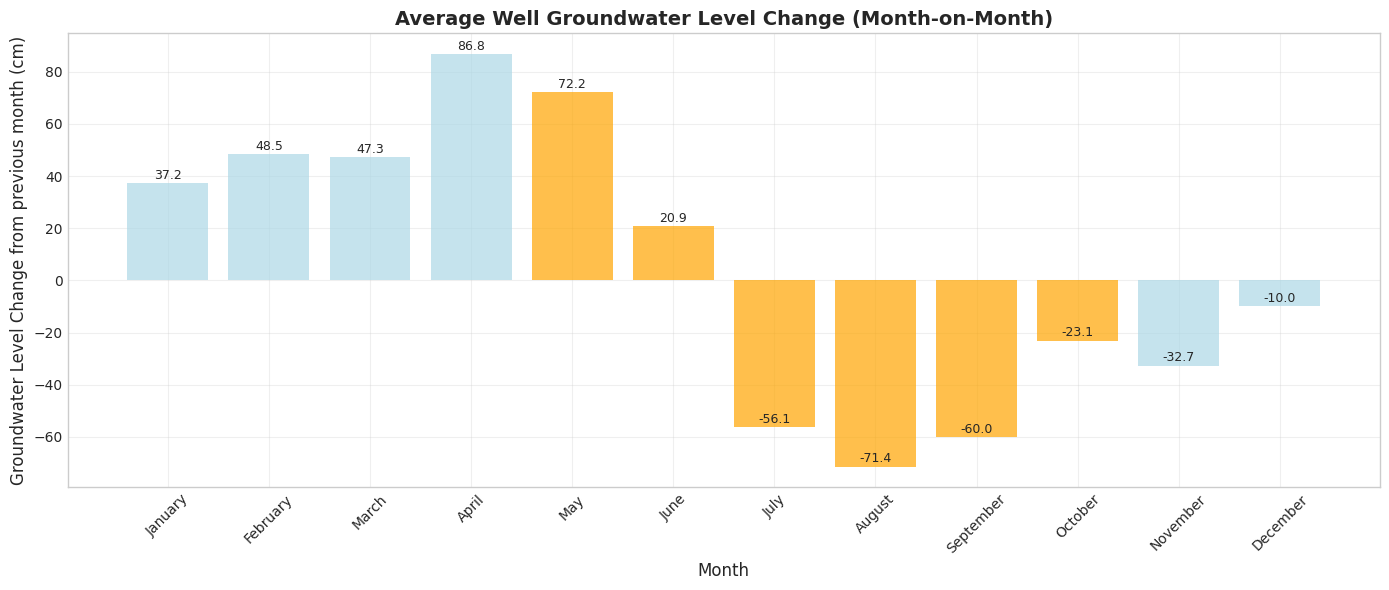

Well analysis complete


In [16]:
wells_df = analyse_wells(roi_bounds)

**GRACE & GLDAS**

In [17]:
def analyse_grace_gldas(roi_bounds, grace_folder, gldas_folder, year, wet_season_months):

    minx, miny, maxx, maxy = roi_bounds
    print(f"Original ROI bounds: lon({minx}, {maxx}), lat({miny}, {maxy})")

    grace_minx = minx + 360 if minx < 0 else minx
    grace_maxx = maxx + 360 if maxx < 0 else maxx
    print(f"GRACE ROI bounds: lon({grace_minx}, {grace_maxx}), lat({miny}, {maxy})")

    gldas_miny = max(miny, -59.88)
    gldas_maxy = min(maxy, 89.88)
    if gldas_miny != miny or gldas_maxy != maxy:
        print(f" Adjusted GLDAS lat bounds to: ({gldas_miny}, {gldas_maxy})")
        print(f" Original bounds ({miny}, {maxy}) extend beyond GLDAS coverage")

    monthly_grace_data = []

    months_to_process = [(2018, 12)] + [(year, month) for month in range(1, 13)]

    for process_year, month in months_to_process:
        try:
            grace_files = [f for f in os.listdir(grace_folder)
                           if f.endswith('.nc') and f'_{process_year}_{month}_' in f]
            gldas_files = [f for f in os.listdir(gldas_folder)
                           if f.endswith('.nc4') and f'.A{process_year}{month:02d}' in f]

            if not grace_files or not gldas_files:
                print(f"{calendar.month_name[month]} {process_year}: Missing files")
                continue

            grace_file = os.path.join(grace_folder, grace_files[0])
            gldas_file = os.path.join(gldas_folder, gldas_files[0])

            print(f" Processing {calendar.month_name[month]} {process_year}")
            print(f" GRACE: {grace_files[0]}")
            print(f" GLDAS: {gldas_files[0]}")

            # Process GRACE (Total Water Storage)
            grace_ds = xr.open_dataset(grace_file)

            print(f" GRACE variables: {list(grace_ds.variables.keys())}")
            print(f" GRACE coordinates: {list(grace_ds.coords.keys())}")
            print(f" GRACE lon range: {grace_ds.lon.min().values:.2f} to {grace_ds.lon.max().values:.2f}")
            print(f" GRACE lat range: {grace_ds.lat.min().values:.2f} to {grace_ds.lat.max().values:.2f}")

            # Find GRACE variable
            grace_var = None
            for var_name in ['lwe_thickness', 'tws', 'water_depth', 'equivalent_water_thickness']:
                if var_name in grace_ds.variables:
                    grace_var = grace_ds[var_name]
                    print(f"        Found GRACE variable: {var_name}")
                    break

            if grace_var is None:
                print(f"{calendar.month_name[month]} {process_year}: No GRACE variable found")
                continue

            data_minx, data_maxx = grace_ds.lon.min().values, grace_ds.lon.max().values
            data_miny, data_maxy = grace_ds.lat.min().values, grace_ds.lat.max().values

            print(f" Using GRACE bounds: lon({grace_minx}, {grace_maxx}), lat({miny}, {maxy})")

            if not (data_minx <= grace_minx <= data_maxx and data_minx <= grace_maxx <= data_maxx):
                print(f"Converted longitude bounds ({grace_minx}, {grace_maxx}) outside data range ({data_minx:.2f}, {data_maxx:.2f})")
            if not (data_miny <= miny <= data_maxy and data_miny <= maxy <= data_maxy):
                print(f"Latitude bounds ({miny}, {maxy}) outside data range ({data_miny:.2f}, {data_maxy:.2f})")

            try:
                grace_regional = grace_var.where(
                    (grace_ds.lon >= grace_minx) & (grace_ds.lon <= grace_maxx) &
                    (grace_ds.lat >= miny) & (grace_ds.lat <= maxy),
                    drop=True
                )

                valid_data = grace_regional.values[~np.isnan(grace_regional.values)]
                if len(valid_data) == 0:
                    print(f"No valid GRACE data in ROI for {calendar.month_name[month]} {process_year}")
                    continue

                grace_tws_mean = np.nanmean(valid_data) * 100  # Convert meters to cm
                print(f" GRACE TWS: {grace_tws_mean:.4f} cm (from {len(valid_data)} pixels)")

            except Exception as e:
                print(f"GRACE extraction error: {e}")
                continue

            # Process GLDAS
            gldas_ds = xr.open_dataset(gldas_file)

            print(f"GLDAS variables: {list(gldas_ds.variables.keys())}")
            print(f"GLDAS lon range: {gldas_ds.lon.min().values:.2f} to {gldas_ds.lon.max().values:.2f}")
            print(f"GLDAS lat range: {gldas_ds.lat.min().values:.2f} to {gldas_ds.lat.max().values:.2f}")

            # Sum soil moisture layers
            soil_moisture_total = 0
            soil_layers = ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst',
                           'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']

            for var in soil_layers:
                if var in gldas_ds.variables:
                    var_data = gldas_ds[var]
                    if 'time' in var_data.dims:
                        var_data = var_data.isel(time=0)

                    var_regional = var_data.where(
                        (gldas_ds.lon >= minx) & (gldas_ds.lon <= maxx) &
                        (gldas_ds.lat >= gldas_miny) & (gldas_ds.lat <= gldas_maxy),
                        drop=True
                    )

                    layer_mean = np.nanmean(var_regional.values)
                    if not np.isnan(layer_mean):
                        soil_moisture_total += layer_mean
                        print(f"        {var}: {layer_mean:.2f} kg/m²")

            # Add snow water equivalent
            snow_total = 0
            if 'SWE_inst' in gldas_ds.variables:
                snow_data = gldas_ds['SWE_inst']
                if 'time' in snow_data.dims:
                    snow_data = snow_data.isel(time=0)

                swe_regional = snow_data.where(
                    (gldas_ds.lon >= minx) & (gldas_ds.lon <= maxx) &
                    (gldas_ds.lat >= gldas_miny) & (gldas_ds.lat <= gldas_maxy),
                    drop=True
                )
                snow_total = np.nanmean(swe_regional.values)
                if np.isnan(snow_total):
                    snow_total = 0
                print(f"        Snow (SWE): {snow_total:.2f} kg/m²")

            # Add canopy water storage
            canopy_total = 0
            if 'CanopInt_inst' in gldas_ds.variables:
                canopy_data = gldas_ds['CanopInt_inst']
                if 'time' in canopy_data.dims:
                    canopy_data = canopy_data.isel(time=0)

                canopy_regional = canopy_data.where(
                    (gldas_ds.lon >= minx) & (gldas_ds.lon <= maxx) &
                    (gldas_ds.lat >= gldas_miny) & (gldas_ds.lat <= gldas_maxy),
                    drop=True
                )
                canopy_total = np.nanmean(canopy_regional.values)
                if np.isnan(canopy_total):
                    canopy_total = 0
                print(f"        Canopy: {canopy_total:.2f} kg/m²")

            # Calculate total surface water storage (convert kg/m² to cm)
            surface_water_total = (soil_moisture_total + snow_total + canopy_total) / 10.0
            print(f"        Total surface water: {surface_water_total:.4f} cm")

            # Calculate groundwater anomaly (GRACE TWS - surface water components)
            groundwater_anomaly = grace_tws_mean - surface_water_total

            monthly_grace_data.append({
                'process_month': month,
                'process_year': process_year,
                'month_name': calendar.month_name[month],
                'season': 'wet' if month in wet_season_months else 'dry',
                'groundwater_anomaly': groundwater_anomaly,
                'total_water_storage': grace_tws_mean
            })

            print(f"{calendar.month_name[month]} {process_year}: GWA = {groundwater_anomaly:.4f} cm, TWS = {grace_tws_mean:.4f} cm")

            grace_ds.close()
            gldas_ds.close()

        except Exception as e:
            print(f"{calendar.month_name[month]} {process_year}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    monthly_grace_df = pd.DataFrame(monthly_grace_data)
    monthly_grace_df = monthly_grace_df.reset_index(drop=True)
    monthly_grace_df['mean_storage_change'] = monthly_grace_df['groundwater_anomaly'].diff()
    final_df = monthly_grace_df[monthly_grace_df['process_year'] == year].copy().reset_index(drop=True)
    final_df['month'] = range(1, 13)

    final_df = final_df.drop(['process_month', 'process_year'], axis=1)

    try:
        create_grace_change_plot(final_df)
    except Exception as e:
        print(f"Plot creation failed: {e}")
        import traceback
        traceback.print_exc()

    return final_df

In [18]:
def create_grace_change_plot(monthly_grace_df):

    plot_df = monthly_grace_df.copy()

    fig, ax1 = plt.subplots(figsize=(14, 6))

    colors = ['lightblue' if row['season'] == 'wet' else 'orange'
              for _, row in plot_df.iterrows()]

    bars = ax1.bar(plot_df['month_name'], plot_df['mean_storage_change'],
                   capsize=5, color=colors, alpha=0.7)

    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('GRACE/GLDAS Groundwater Level Change (Month-on-Month)', fontweight='bold')
    ax1.set_ylabel('Groundwater Level Change from previous month (cm)')
    ax1.set_xlabel('Month')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    for i, (_, row) in enumerate(plot_df.iterrows()):
        y_pos = row['mean_storage_change'] + 0.5
        va_align = 'bottom' if row['mean_storage_change'] >= 0 else 'top'
        ax1.text(i, y_pos,
                 f"{row['mean_storage_change']:.1f}", ha='center', va=va_align, fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'grace_gwa_change_analysis_with_baseline.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

Original ROI bounds: lon(-60.79301306799832, -58.182940382825784), lat(-3.742732482304937, -1.701554491878766)
GRACE ROI bounds: lon(299.20698693200166, 301.8170596171742), lat(-3.742732482304937, -1.701554491878766)
 Processing December 2018
 GRACE: GRD-3_2018_12_GRFO_UTCSR_BA01_0603_LND_v04.nc
 GLDAS: GLDAS_NOAH025_M.A201812.021.nc4
 GRACE variables: ['lon', 'lat', 'time', 'lwe_thickness', 'uncertainty', 'lat_bounds', 'lon_bounds', 'time_bounds']
 GRACE coordinates: ['lon', 'lat', 'time']
 GRACE lon range: 0.50 to 359.50
 GRACE lat range: -89.50 to 89.50
        Found GRACE variable: lwe_thickness
 Using GRACE bounds: lon(299.20698693200166, 301.8170596171742), lat(-3.742732482304937, -1.701554491878766)
 GRACE TWS: -26.7143 cm (from 6 pixels)
GLDAS variables: ['time', 'time_bnds', 'lon', 'lat', 'Swnet_tavg', 'Lwnet_tavg', 'Qle_tavg', 'Qh_tavg', 'Qg_tavg', 'Snowf_tavg', 'Rainf_tavg', 'Evap_tavg', 'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'AvgSurfT_inst', 'Albedo_inst', 'SWE_inst', 'SnowDepth_i

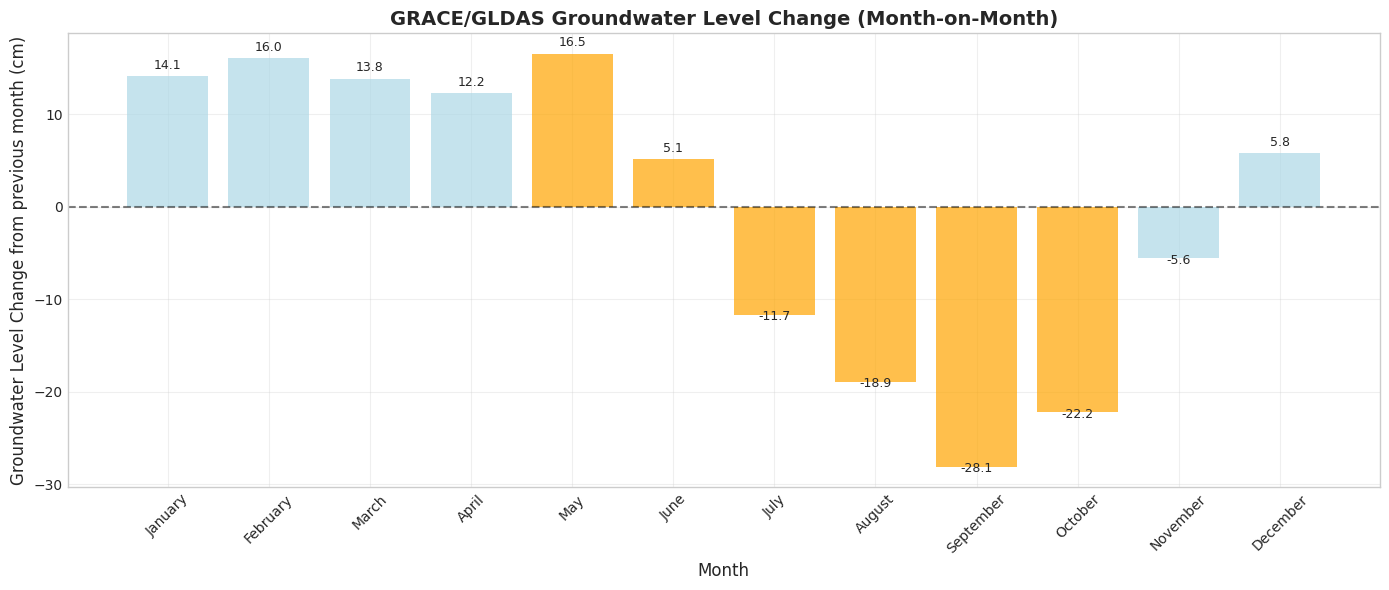

In [19]:
groundwater_data_df = analyse_grace_gldas(roi_bounds, grace_folder, gldas_folder, year, wet_season_months)

**Sentinel-1**

In [21]:
def process_sentinel1_backscatter(sentinel1_folder=sentinel1_folder, year=year):

    monthly_s1_data = []

    for month in range(1, 13):
        try:
            year_month_str = f"{year}{month:02d}"
            month_folder = os.path.join(sentinel1_folder, year_month_str)

            if not os.path.exists(month_folder):
                print(f" {calendar.month_name[month]}: Folder not found")
                continue

            safe_folders = [f for f in os.listdir(month_folder) if f.endswith('.SAFE')]
            if not safe_folders:
                print(f" {calendar.month_name[month]}: No SAFE folders")
                continue

            safe_folder = os.path.join(month_folder, safe_folders[0])
            measurement_folder = os.path.join(safe_folder, 'measurement')

            if not os.path.exists(measurement_folder):
                print(f"{calendar.month_name[month]}: Measurement folder not found")
                continue

            # Find VV and VH TIFF files
            tiff_files = [f for f in os.listdir(measurement_folder)
                         if f.lower().endswith(('.tiff', '.tif'))]
            vv_files = [f for f in tiff_files if 'vv' in f.lower()]
            vh_files = [f for f in tiff_files if 'vh' in f.lower()]

            if not (vv_files and vh_files):
                print(f"{calendar.month_name[month]}: Missing VV or VH polarization data")
                continue

            vv_file = os.path.join(measurement_folder, vv_files[0])
            vh_file = os.path.join(measurement_folder, vh_files[0])

            with rasterio.open(vv_file) as src_vv, rasterio.open(vh_file) as src_vh:
                window = rasterio.windows.Window(0, 0, min(src_vv.width, 2000), min(src_vv.height, 2000))
                vv_data = src_vv.read(1, window=window).astype(float)
                vh_data = src_vh.read(1, window=window).astype(float)

                vv_data = vv_data[vv_data != src_vv.nodata]
                vv_data = vv_data[np.isfinite(vv_data)]
                vh_data = vh_data[vh_data != src_vh.nodata]
                vh_data = vh_data[np.isfinite(vh_data)]

                if len(vv_data) > 0 and len(vh_data) > 0:
                    mean_vv = np.mean(vv_data)
                    std_vv = np.std(vv_data)
                    mean_vh = np.mean(vh_data)
                    std_vh = np.std(vh_data)

                    monthly_s1_data.append({
                        'month': month,
                        'month_name': calendar.month_name[month],
                        'season': 'wet' if month in wet_season_months else 'dry',
                        'mean_vv': mean_vv,
                        'std_vv': std_vv,
                        'mean_vh': mean_vh,
                        'std_vh': std_vh
                    })

                    print(f"{calendar.month_name[month]}: VV = {mean_vv:.2f} dB, VH = {mean_vh:.2f} dB")

        except Exception as e:
            print(f"{calendar.month_name[month]}: {e}")
            continue

    monthly_s1_df = pd.DataFrame(monthly_s1_data)
    if not monthly_s1_df.empty:
        plot_sentinel1_backscatter(monthly_s1_df)
    return monthly_s1_df

In [22]:
def plot_sentinel1_backscatter(monthly_s1_df, output_folder=output_folder):

    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

    months = monthly_s1_df['month'].values
    month_names = [name[:3] for name in monthly_s1_df['month_name']]

    ax1.plot(months, monthly_s1_df['mean_vv'], 'o-', label='VV Backscatter', color='blue')
    ax1.plot(months, monthly_s1_df['mean_vh'], 's-', label='VH Backscatter', color='green')

    ax1.set_title('Sentinel-1 Backscatter (Monthly Averages)', fontweight='bold')
    ax1.set_ylabel('Backscatter (dB)')
    ax1.set_xlabel('Month')
    ax1.set_xticks(months)
    ax1.set_xticklabels(month_names)
    ax1.legend()
    ax1.grid(False)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'sentinel1_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

January: VV = 261.83 dB, VH = 138.33 dB
February: VV = 255.75 dB, VH = 133.09 dB
March: VV = 249.25 dB, VH = 127.88 dB
April: VV = 257.43 dB, VH = 132.48 dB
May: VV = 252.71 dB, VH = 131.51 dB
June: VV = 257.29 dB, VH = 132.12 dB
July: VV = 264.14 dB, VH = 135.04 dB
August: VV = 250.40 dB, VH = 130.46 dB
September: VV = 252.39 dB, VH = 130.29 dB
October: VV = 254.07 dB, VH = 135.99 dB
November: VV = 248.24 dB, VH = 129.08 dB
December: VV = 248.19 dB, VH = 126.26 dB


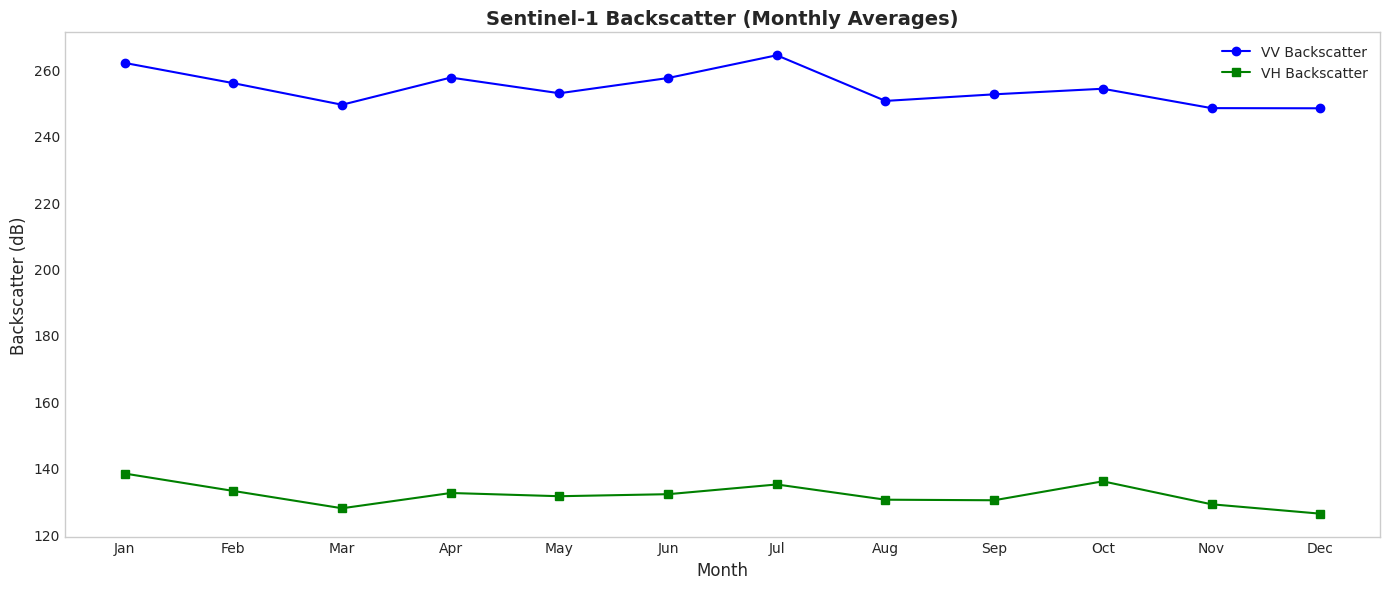

In [23]:
s1_df = process_sentinel1_backscatter(sentinel1_folder, year=year)

In [24]:
def plot_sentinel1_backscatter_normalised(monthly_s1_df, output_folder=output_folder):
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

    months = monthly_s1_df['month'].values
    month_names = [name[:3] for name in monthly_s1_df['month_name']]

    # Normalise VV to 0-1
    min_vv = monthly_s1_df['mean_vv'].min()
    max_vv = monthly_s1_df['mean_vv'].max()
    normalized_vv = (monthly_s1_df['mean_vv'] - min_vv) / (max_vv - min_vv)

    # Normalise VH to 0-1
    min_vh = monthly_s1_df['mean_vh'].min()
    max_vh = monthly_s1_df['mean_vh'].max()
    normalized_vh = (monthly_s1_df['mean_vh'] - min_vh) / (max_vh - min_vh)


    ax1.plot(months, normalized_vv, 'o-', label='VV Backscatter (Normalised)', color='blue')
    ax1.plot(months, normalized_vh, 's-', label='VH Backscatter (Normalised)', color='green')

    ax1.set_title('Sentinel-1 Backscatter (Normalised Monthly Averages)', fontweight='bold')
    ax1.set_ylabel('Normalised Backscatter (0-1)')
    ax1.set_xlabel('Month')
    ax1.set_xticks(months)
    ax1.set_xticklabels(month_names)
    ax1.legend()
    ax1.grid(False)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'sentinel1_normalized_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

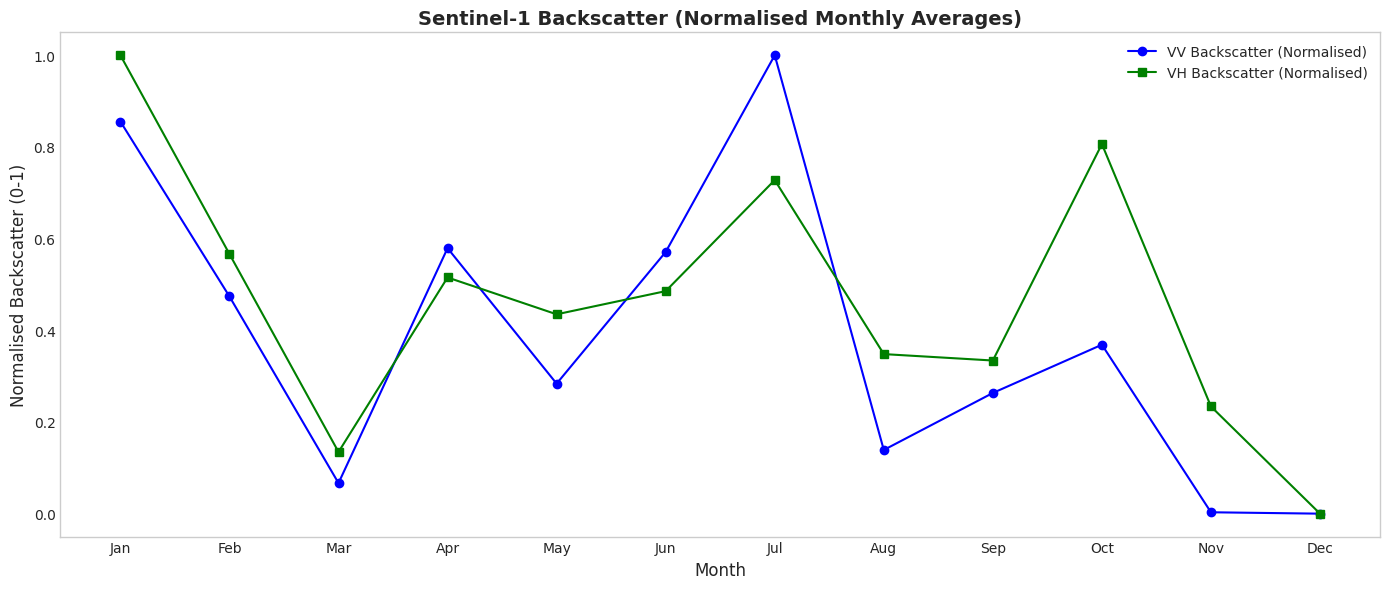

In [25]:
plot_sentinel1_backscatter_normalised(s1_df, output_folder=output_folder)

# **Integrating datasets for Machine Learning Model**

In [26]:
class TemporalFeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            months = X['month'].values
        else:
            months = X[:, 0]

        temporal_features = np.column_stack([
            np.sin(2 * np.pi * months / 12),
            np.cos(2 * np.pi * months / 12)
        ])
        return temporal_features

In [27]:
def create_ml_dataset(grace_df, wells_df, s1_df, include_season=False):

    required_cols = {
        'grace_df': ['month', 'mean_storage_change'],
        'wells_df': ['month', 'mean_storage_change'],
        's1_df': ['month', 'mean_vv', 'mean_vh']
    }

    for df_name, cols in required_cols.items():
        df = locals()[df_name]
        missing_cols = [col for col in cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"{df_name} missing columns: {missing_cols}")

    ml_data = []
    for _, grace_row in grace_df.iterrows():
        month = grace_row['month']
        well_month = wells_df[wells_df['month'] == month]
        s1_month = s1_df[s1_df['month'] == month]

        if len(well_month) > 0 and len(s1_month) > 0:
            data_point = {
                'month': month,
                'grace_storage_change': grace_row['mean_storage_change'],
                'grace_gwa': grace_row.get('groundwater_anomaly', 0),
                'grace_tws': grace_row.get('total_water_storage', 0),
                's1_mean_vv': s1_month.iloc[0]['mean_vv'],
                's1_mean_vh': s1_month.iloc[0]['mean_vh'],
                'wells_target': well_month.iloc[0]['mean_storage_change']
            }

            if include_season and 'season' in grace_row:
                data_point['season'] = 1 if grace_row['season'] == 'wet' else 0

            ml_data.append(data_point)

    df = pd.DataFrame(ml_data)

    print(f" Created dataset with {len(df)} samples")
    print(f" Date range: {df['month'].min()} to {df['month'].max()}")
    print(f" GRACE change range: {df['grace_storage_change'].min():.2f} to {df['grace_storage_change'].max():.2f} cm")

    return df

In [28]:
ml_dataset = create_ml_dataset(groundwater_data_df, wells_df, s1_df, include_season=False)

 Created dataset with 12 samples
 Date range: 1 to 12
 GRACE change range: -28.09 to 16.48 cm


# **Machine Learning Pipeline**

In [30]:
def create_ml_pipelines():

    numerical_features = ['grace_storage_change', 'grace_gwa', 's1_mean_vh', 's1_mean_vv']
    use_temporal = True

    preprocessors = []

    numerical_transformer = StandardScaler()
    preprocessors.append(('numerical', numerical_transformer, numerical_features))

    if use_temporal:
        temporal_transformer = Pipeline([
            ('temporal', TemporalFeatureTransformer()),
            ('scaler', StandardScaler())
        ])
        preprocessors.append(('temporal', temporal_transformer, ['month']))

    preprocessor = ColumnTransformer(
        transformers=preprocessors,
        remainder='drop'
    )

    models = {
        'LinearRegression': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        'Ridge_Medium': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=10.0))
        ]),
        'BayesianRidge': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', BayesianRidge(
                alpha_1=1e-3, alpha_2=1e-3,
                lambda_1=1e-3, lambda_2=1e-3,
                compute_score=True
            ))
        ])
    }

    print(f" Features: {numerical_features}")
    print(f" Temporal features: {use_temporal}")
    print(f" Models: Linear, Ridge, Bayesian")

    return models, numerical_features

In [31]:
models, feature_names = create_ml_pipelines()

 Features: ['grace_storage_change', 'grace_gwa', 's1_mean_vh', 's1_mean_vv']
 Temporal features: True
 Models: Linear, Ridge, Bayesian


In [32]:
models

{'LinearRegression': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                   ['grace_storage_change',
                                                    'grace_gwa', 's1_mean_vh',
                                                    's1_mean_vv']),
                                                  ('temporal',
                                                   Pipeline(steps=[('temporal',
                                                                    TemporalFeatureTransformer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['month'])])),
                 ('regressor', LinearRegression())]),
 'Ridge_Medium': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('numerical'

# **Cross-Validation Training**

In [33]:
def validate_models_with_cv(models, X, y, cv_method='loo'):

    loo = LeaveOneOut()
    results = {}

    for name, pipeline in models.items():
        print(f"\nValidating {name}...")

        predictions = []
        actuals = []
        fold_errors = []

        for fold, (train_idx, test_idx) in enumerate(loo.split(X)):
            if hasattr(X, 'iloc'):
                X_train = X.iloc[train_idx]
                X_test = X.iloc[test_idx]
            else:
                X_train = X[train_idx]
                X_test = X[test_idx]

            if hasattr(y, 'iloc'):
                y_train = y.iloc[train_idx]
                y_test = y.iloc[test_idx]
                actual = y_test.iloc[0]
            else:
                y_train = y[train_idx]
                y_test = y[test_idx]
                actual = y_test[0]

            pipeline.fit(X_train, y_train)
            pred = pipeline.predict(X_test)[0]

            predictions.append(pred)
            actuals.append(actual)
            fold_errors.append(abs(actual - pred))

        predictions = np.array(predictions)
        actuals = np.array(actuals)

        try:
            ss_res = np.sum((actuals - predictions) ** 2)
            ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 1e-10 else 0.0

            if np.isnan(r2) or np.isinf(r2):
                r2 = -999.0

        except:
            r2 = -999.0

        mae = np.mean(fold_errors)
        mae_std = np.std(fold_errors)

        results[name] = {
            'test_r2_mean': r2,
            'test_r2_std': 0.0,
            'test_mae_mean': mae,
            'test_mae_std': mae_std,
            'train_r2_mean': 0.0,
            'overfitting': 0.0,
            'predictions': predictions,
            'actuals': actuals
        }

        if r2 > -999:
            print(f"  Test R² = {r2:.3f}")
        else:
            print(f"  Test R² = INVALID (numerical issues)")
        print(f"  Test MAE = {mae:.3f} ± {mae_std:.3f} cm")
        print(f"  Max error = {np.max(fold_errors):.3f} cm")
        print(f"  Min error = {np.min(fold_errors):.3f} cm")

    return results

In [34]:
cv_results = validate_models_with_cv(models, ml_dataset, ml_dataset['wells_target'])


Validating LinearRegression...
  Test R² = 0.822
  Test MAE = 17.465 ± 13.246 cm
  Max error = 49.286 cm
  Min error = 0.734 cm

Validating Ridge_Medium...
  Test R² = 0.586
  Test MAE = 25.327 ± 21.808 cm
  Max error = 70.279 cm
  Min error = 4.757 cm

Validating BayesianRidge...
  Test R² = 0.674
  Test MAE = 25.103 ± 15.867 cm
  Max error = 57.503 cm
  Min error = 3.414 cm


In [35]:
def get_cv_correlations(models, X, y, target_name='wells_target', output_folder='output_plots'):

    loo = LeaveOneOut()

    for fold, (train_idx, test_idx) in enumerate(loo.split(X)):
        if fold == 0:
            X_train = X.iloc[train_idx]
            y_train = y.iloc[train_idx]

            cv_model = models['LinearRegression']
            cv_model.fit(X_train, y_train)

            preprocessor = cv_model.named_steps['preprocessor']
            X_transformed = preprocessor.transform(X)

            try:
                feature_names = preprocessor.get_feature_names_out()
            except:
                feature_names = ['grace_storage_change', 'grace_gwa', 's1_mean_vh', 's1_mean_vv', 'month_sin', 'month_cos']

            df_transformed = pd.DataFrame(X_transformed, columns=feature_names)
            df_transformed[target_name] = y.values

            correlation_matrix = df_transformed.corr()
            target_correlations = correlation_matrix[[target_name]].drop(target_name)

            plt.figure(figsize=(6, max(4, len(target_correlations))))
            sns.heatmap(target_correlations, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
            plt.title(f'Feature correlation with {target_name}', fontsize=14)
            plt.yticks(rotation=0)
            plt.tight_layout()
            os.makedirs(output_folder, exist_ok=True)
            plt.savefig(os.path.join(output_folder, 'feature_correlation_with_wells_target.png'), dpi=300, bbox_inches='tight')
            plt.show()

            return target_correlations
            break

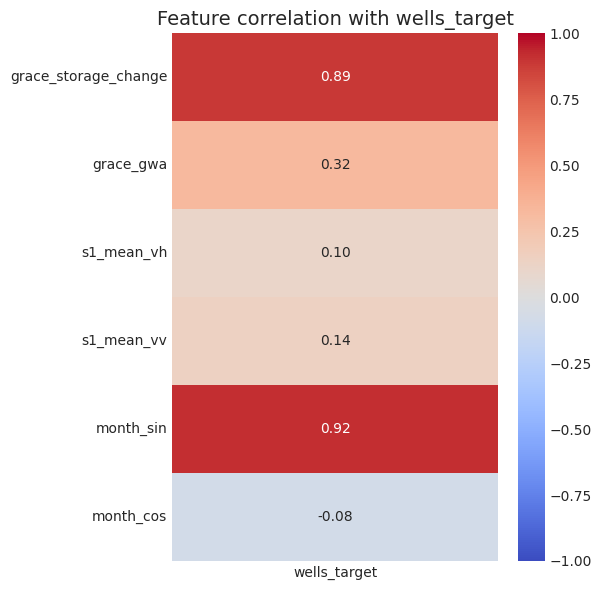

In [36]:
X = ml_dataset.drop('wells_target', axis=1)
y = ml_dataset['wells_target']
cv_correlations = get_cv_correlations(models, X, y, output_folder=output_folder)

# **Uncertainty Quantifications**

In [37]:
def uncertainty_quantification(bayesian_pipeline, X, y, months, n_bootstrap=100):

    bayesian_pipeline.fit(X, y)

    #Bayesian predictions with uncertainty
    regressor = bayesian_pipeline.named_steps['regressor']
    X_transformed = bayesian_pipeline.named_steps['preprocessor'].transform(X)

    y_pred, y_std = regressor.predict(X_transformed, return_std=True)

    # Bootstrap
    print("Computing bootstrap confidence intervals...")
    bootstrap_preds = []

    np.random.seed(42)
    for i in range(n_bootstrap):
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X.iloc[indices] if hasattr(X, 'iloc') else X[indices]
        y_boot = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]

        boot_pipeline = bayesian_pipeline.__class__(bayesian_pipeline.steps)
        boot_pipeline.fit(X_boot, y_boot)
        boot_pred = boot_pipeline.predict(X)
        bootstrap_preds.append(boot_pred)

    bootstrap_preds = np.array(bootstrap_preds)
    bootstrap_std = np.std(bootstrap_preds, axis=0)
    bootstrap_lower = np.percentile(bootstrap_preds, 2.5, axis=0)
    bootstrap_upper = np.percentile(bootstrap_preds, 97.5, axis=0)

    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    print(f"Bayesian Uncertainty Quantification:")
    print(f"  R² = {r2:.3f}")
    print(f"  MAE = {mae:.3f} cm")
    print(f"  Mean Bayesian uncertainty: ±{np.mean(y_std):.3f} cm")
    print(f"  Mean Bootstrap uncertainty: ±{np.mean(bootstrap_std):.3f} cm")

    plot_uncertainty(months, y, y_pred, y_std, bootstrap_lower, bootstrap_upper)

    return {
        'model': bayesian_pipeline,
        'r2': r2,
        'mae': mae,
        'predictions': y_pred,
        'bayesian_uncertainty': y_std,
        'bootstrap_uncertainty': bootstrap_std,
        'bootstrap_ci_lower': bootstrap_lower,
        'bootstrap_ci_upper': bootstrap_upper,
        'mean_bayesian_uncertainty': np.mean(y_std),
        'mean_bootstrap_uncertainty': np.mean(bootstrap_std)
    }

In [38]:
def plot_uncertainty(months, y_true, y_pred, bayesian_std, bootstrap_lower, bootstrap_upper):

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.plot(months, y_true, 'o-', label='Observed Wells', color='blue', linewidth=2, markersize=8)
    ax.plot(months, y_pred, 's-', label='Bayesian Prediction', color='red', linewidth=2, markersize=6)

    # Bayesian uncertainty
    ax.fill_between(months, y_pred - 2*bayesian_std, y_pred + 2*bayesian_std,
                    alpha=0.2, color='red', label='Bayesian 95% CI')

    # Bootstrap uncertainty
    ax.fill_between(months, bootstrap_lower, bootstrap_upper,
                    alpha=0.3, color='green', label='Bootstrap 95% CI')

    ax.set_xticks(months)
    ax.set_xticklabels([calendar.month_name[m] for m in months], rotation=45, ha='right')

    ax.set_xlabel('Month')
    ax.set_ylabel('Groundwater Level Change from Previous Month (cm)')
    ax.set_title('Time Series Prediction with Uncertainty Bounds')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'uncertainty_time_series.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

Computing bootstrap confidence intervals...
Bayesian Uncertainty Quantification:
  R² = 0.905
  MAE = 13.642 cm
  Mean Bayesian uncertainty: ±22.767 cm
  Mean Bootstrap uncertainty: ±36.347 cm


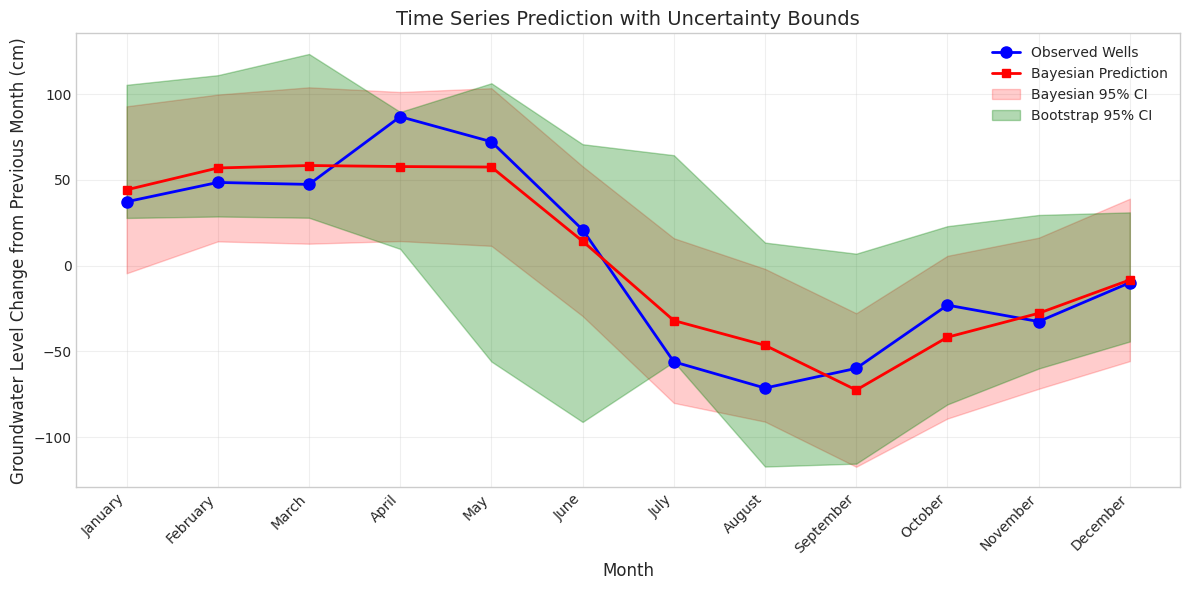

In [39]:
uncertainty_results = uncertainty_quantification(models['BayesianRidge'], ml_dataset, ml_dataset['wells_target'], ml_dataset['month'])

In [40]:
def train_final_models(models, X, y):

    trained_models = {}

    for name, pipeline in models.items():
        print(f"\nTraining {name}...")

        pipeline.fit(X, y)
        y_pred = pipeline.predict(X)

        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)

        regressor = pipeline.named_steps['regressor']
        feature_importance = None

        if hasattr(regressor, 'feature_importances_'):
            feature_importance = regressor.feature_importances_
        elif hasattr(regressor, 'coef_'):
            feature_importance = np.abs(regressor.coef_)

        try:
            feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        except:
            n_features = pipeline.named_steps['preprocessor'].transform(X).shape[1]
            feature_names = [f'feature_{i}' for i in range(n_features)]

        trained_models[name] = {
            'pipeline': pipeline,
            'r2': r2,
            'mae': mae,
            'predictions': y_pred,
            'feature_importance': feature_importance,
            'feature_names': feature_names
        }

        print(f"  R² = {r2:.3f}")
        print(f"  MAE = {mae:.3f} cm")

        model_path = os.path.join(output_folder, f'{name.lower()}_model.joblib')
        joblib.dump(pipeline, model_path)

    return trained_models

In [41]:
trained_models = train_final_models(models, ml_dataset, ml_dataset['wells_target'])


Training LinearRegression...
  R² = 0.968
  MAE = 7.509 cm

Training Ridge_Medium...
  R² = 0.781
  MAE = 18.853 cm

Training BayesianRidge...
  R² = 0.905
  MAE = 13.642 cm


In [45]:
def feature_importance_analysis_cv(models, X, y, n_repeats=10):

    importance_results = {}
    loo = LeaveOneOut()

    for fold, (train_idx, test_idx) in enumerate(loo.split(X)):
        if fold == 0:
            X_train = X.iloc[train_idx]
            y_train = y.iloc[train_idx]

            for model_name, pipeline in models.items():
                print(f"\nAnalyzing {model_name} (CV-trained)...")

                cv_pipeline = pipeline
                cv_pipeline.fit(X_train, y_train)

                regressor = cv_pipeline.named_steps['regressor']
                n_features = cv_pipeline.named_steps['preprocessor'].transform(X).shape[1]

                numerical_features = ['grace_storage_change', 'grace_gwa', 's1_mean_vh', 's1_mean_vv']
                temporal_features = ['month_sin', 'month_cos']
                transformed_feature_names = numerical_features + temporal_features

                print(f"  Using feature names: {transformed_feature_names}")
                print(f"  Total features: {len(transformed_feature_names)} (matches shape: {n_features})")

                importance_methods = {}

                # Coefficient-based importance
                if hasattr(regressor, 'coef_'):
                    importance_methods['coefficients'] = np.abs(regressor.coef_)
                    print(f" Coefficient-based importance available")

                # Permutation importance
                try:
                    print(f" Computing permutation importance...")
                    perm_importance = permutation_importance(
                        cv_pipeline, X, y,
                        n_repeats=n_repeats,
                        random_state=42,
                        n_jobs=-1
                    )
                    importance_methods['permutation'] = perm_importance.importances_mean
                    importance_methods['permutation_std'] = perm_importance.importances_std
                    print(f"  Permutation importance computed")
                except Exception as e:
                    print(f"  Permutation importance failed: {str(e)}")

                y_pred_full = cv_pipeline.predict(X)
                current_r2 = r2_score(y, y_pred_full)
                current_mae = mean_absolute_error(y, y_pred_full)


                importance_results[model_name] = {
                    'methods': importance_methods,
                    'feature_names': transformed_feature_names,
                    'r2_score': current_r2,
                    'mae_score': current_mae
                }

                if 'permutation' in importance_methods:
                    importance = importance_methods['permutation']
                    sorted_idx = np.argsort(importance)[::-1]
                    print(f"  Top 5 features by permutation importance:")
                    for i in range(min(5, len(sorted_idx))):
                        idx = sorted_idx[i]
                        feat_name = transformed_feature_names[idx]
                        feat_importance = importance[idx]
                        feat_std = importance_methods['permutation_std'][idx]
                        print(f"    {i+1}. {feat_name}: {feat_importance:.4f} ± {feat_std:.4f}")

                if 'coefficients' in importance_methods:
                    importance = importance_methods['coefficients']
                    sorted_idx = np.argsort(importance)[::-1]
                    print(f"  Top 5 features by coefficient magnitude:")
                    for i in range(min(5, len(sorted_idx))):
                        idx = sorted_idx[i]
                        feat_name = transformed_feature_names[idx]
                        feat_importance = importance[idx]
                        print(f"    {i+1}. {feat_name}: {feat_importance:.4f}")

            break

    plot_feature_importance(importance_results)
    return importance_results

In [46]:
def plot_feature_importance(importance_results):
  n_models = len(importance_results)
  fig, axes = plt.subplots(1, 3, figsize=(18, 6))

  colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

  def clean_feature_name(name):
      name_map = {
          'grace_storage_change': 'GRACE Storage Change',
          'grace_gwa': 'GRACE GWA',
          's1_mean_vh': 'Sentinel-1 VH',
          's1_mean_vv': 'Sentinel-1 VV',
          'month_sin': 'Seasonal (sin)',
          'month_cos': 'Seasonal (cos)'
      }
      return name_map.get(name, name)

  #Permutation importance comparison
  ax1 = axes[0]
  x_offset = 0
  bar_width = 0.25

  model_names = list(importance_results.keys())
  all_features = list(importance_results.values())[0]['feature_names']

  for i, (model_name, results) in enumerate(importance_results.items()):
      if 'permutation' in results['methods']:
          importance = results['methods']['permutation']

          x_pos = np.arange(len(all_features)) + i * bar_width
          bars = ax1.bar(x_pos, importance, bar_width,
                        label=model_name.replace('_', ' '),
                        color=colors[i % len(colors)], alpha=0.8)

  ax1.set_xlabel('Features')
  ax1.set_ylabel('Permutation Importance')
  ax1.set_title('Permutation Feature Importance Comparison')
  ax1.set_xticks(np.arange(len(all_features)) + bar_width * (n_models-1) / 2)
  ax1.set_xticklabels([clean_feature_name(name) for name in all_features], rotation=45, ha='right')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  # Linear Regression Focused
  ax2 = axes[1]
  best_model = max(importance_results.keys(),
                  key=lambda x: importance_results[x]['r2_score'])
  best_results = importance_results[best_model]

  if 'permutation' in best_results['methods']:
      importance = best_results['methods']['permutation']
      feature_names = best_results['feature_names']

      sorted_idx = np.argsort(importance)[::-1]

      bars = ax2.barh(range(len(importance)), importance[sorted_idx],
                     color=colors[0], alpha=0.8)
      ax2.set_yticks(range(len(importance)))
      ax2.set_yticklabels([clean_feature_name(feature_names[i]) for i in sorted_idx])
      ax2.set_xlabel('Importance Score')
      ax2.set_title('Permutation Feature Importance: Linear Regression')
      ax2.grid(True, alpha=0.3)

  # Coefficient magnitude comparison
  ax3 = axes[2]

  for i, (model_name, results) in enumerate(importance_results.items()):
      if 'coefficients' in results['methods']:
          importance = results['methods']['coefficients']

          x_pos = np.arange(len(all_features)) + i * bar_width
          bars = ax3.bar(x_pos, importance, bar_width,
                        label=model_name.replace('_', ' '),
                        color=colors[i % len(colors)], alpha=0.8)

  ax3.set_xlabel('Features')
  ax3.set_ylabel('Coefficient Magnitude')
  ax3.set_title('Coefficient Magnitude Comparison')
  ax3.set_xticks(np.arange(len(all_features)) + bar_width * (n_models-1) / 2)
  ax3.set_xticklabels([clean_feature_name(name) for name in all_features], rotation=45, ha='right')
  ax3.legend()
  ax3.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig(os.path.join(output_folder, 'feature_importance.png'),
              dpi=300, bbox_inches='tight')
  plt.show()


Analyzing LinearRegression (CV-trained)...
  Using feature names: ['grace_storage_change', 'grace_gwa', 's1_mean_vh', 's1_mean_vv', 'month_sin', 'month_cos']
  Total features: 6 (matches shape: 6)
 Coefficient-based importance available
 Computing permutation importance...
  Permutation importance computed
  Top 5 features by permutation importance:
    1. grace_storage_change: 10.0636 ± 2.0028
    2. s1_mean_vh: 8.0192 ± 1.6284
    3. grace_gwa: 1.0150 ± 0.2451
    4. month_cos: 0.2322 ± 0.0674
    5. month_sin: 0.0497 ± 0.0287
  Top 5 features by coefficient magnitude:
    1. grace_gwa: 104.8927
    2. month_cos: 101.4902
    3. month_sin: 47.3188
    4. grace_storage_change: 35.8566
    5. s1_mean_vh: 14.3746

Analyzing Ridge_Medium (CV-trained)...
  Using feature names: ['grace_storage_change', 'grace_gwa', 's1_mean_vh', 's1_mean_vv', 'month_sin', 'month_cos']
  Total features: 6 (matches shape: 6)
 Coefficient-based importance available
 Computing permutation importance...
  Perm

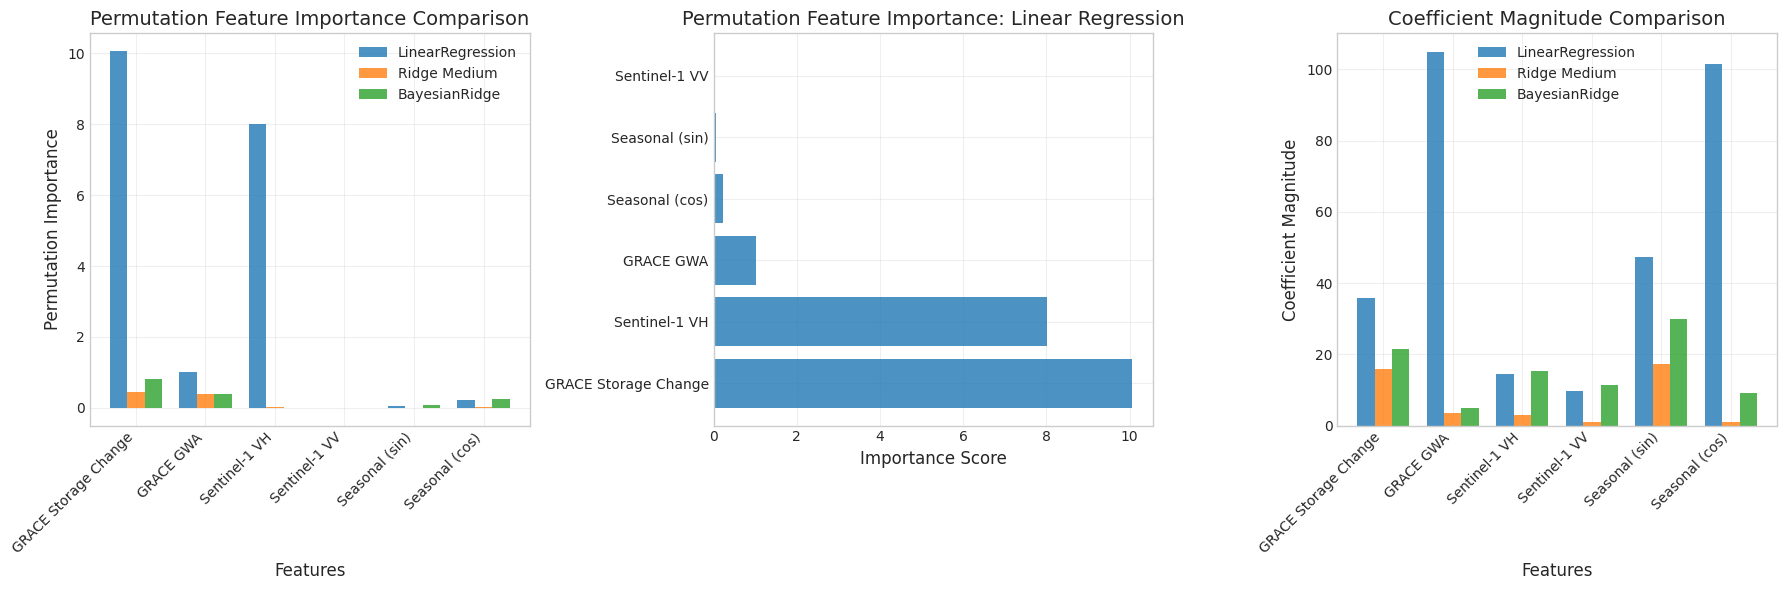

In [47]:
cv_importance_results = feature_importance_analysis_cv(models, X, y)

In [51]:
def plot_results_for_report(cv_results, uncertainty_results, ml_df):

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    ax1 = axes[0, 0]
    model_names = []
    r2_scores = []
    mae_scores = []
    mae_errors = []

    for name, results in cv_results.items():
        if results['test_r2_mean'] > -999:
            model_names.append(name.replace('_', ' '))
            r2_scores.append(results['test_r2_mean'])
            mae_scores.append(results['test_mae_mean'])
            mae_errors.append(results['test_mae_std'])

    x_pos = np.arange(len(model_names))
    bars = ax1.bar(x_pos, r2_scores, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(model_names)])
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Cross-Validation R²')
    ax1.set_title('Model Comparison (Leave-One-Out CV)')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(model_names, rotation=45)
    ax1.grid(True, alpha=0.3)

    for i, (bar, r2) in enumerate(zip(bars, r2_scores)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

    ax2 = axes[0, 1]
    bars2 = ax2.bar(x_pos, mae_scores, yerr=mae_errors, alpha=0.7,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(model_names)], capsize=5)
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Mean Absolute Error (cm)')
    ax2.set_title('Prediction Error Comparison')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_names, rotation=45)
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['test_r2_mean'] if cv_results[x]['test_r2_mean'] > -999 else -999)
    best_results = cv_results[best_model_name]

    actuals = best_results['actuals']
    predictions = best_results['predictions']

    ax3.scatter(actuals, predictions, s=80, alpha=0.7, color='blue', edgecolors='black')
    min_val, max_val = min(actuals.min(), predictions.min()), max(actuals.max(), predictions.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    r2_val = best_results['test_r2_mean']
    mae_val = best_results['test_mae_mean']
    ax3.text(0.05, 0.95, f'R² = {r2_val:.3f}\nMAE = {mae_val:.1f} cm',
            transform=ax3.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax3.set_xlabel('Actual Groundwater Change (cm)')
    ax3.set_ylabel('Predicted Groundwater Change (cm)')
    ax3.set_title(f'Best Model Performance: {best_model_name.replace("_", " ")}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    months = ml_df['month'].values
    wells_actual = ml_df['wells_target'].values

    if uncertainty_results:
        pred_mean = uncertainty_results['predictions']
        pred_std = uncertainty_results['bayesian_uncertainty']

        ax4.plot(months, wells_actual, 'o-', linewidth=2, markersize=8,
                label='Observed Wells', color='blue')
        ax4.plot(months, pred_mean, 's-', linewidth=2, markersize=6,
                label='Bayesian Prediction', color='red')
        ax4.fill_between(months, pred_mean - pred_std, pred_mean + pred_std,
                        alpha=0.3, color='red', label='Bayesian 95% CI')
        ax4.fill_between(months, pred_mean - 2*pred_std, pred_mean + 2*pred_std,
                        alpha=0.2, color='red', label='Bootstrap 95% CI')
    else:
        ax4.plot(months, wells_actual, 'o-', linewidth=2, markersize=8,
                label='Observed Wells', color='blue')
        ax4.plot(months, predictions, 's-', linewidth=2, markersize=6,
                label='Best Model Prediction', color='red')

    ax4.set_xlabel('Month')
    ax4.set_ylabel('Groundwater Storage Change (cm)')
    ax4.set_title('Time Series Prediction with Uncertainty')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'final_ml_results_for_report.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Report figures saved to: {output_folder}/final_ml_results_for_report.png")


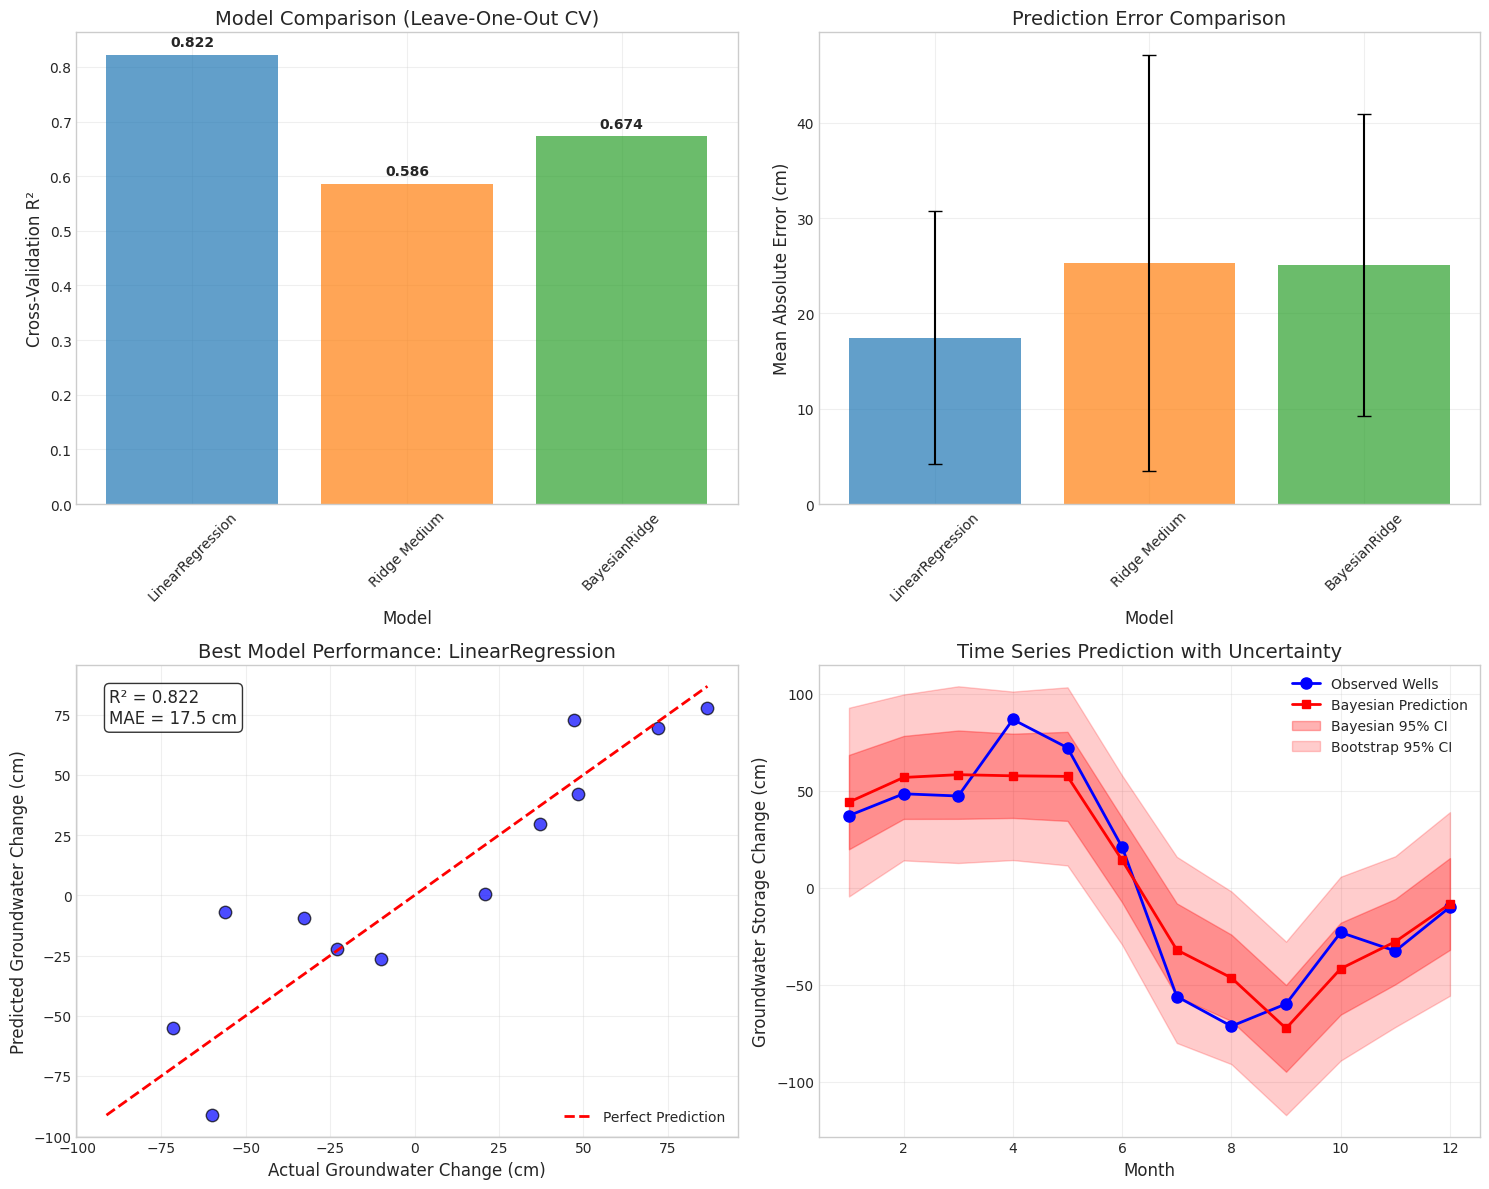

Report figures saved to: /content/drive/MyDrive/Colab Notebooks/AI4EO/Coursework/Groundwater Brazil/Results/Analysis/final_ml_results_for_report.png


In [52]:
plot_results_for_report(cv_results, uncertainty_results, ml_dataset)

In [50]:
env_calculator.end_tracking("Complete Groundwater Analysis", data_size_gb=5.0)

 Completed: Complete Groundwater Analysis
 Duration: 0.110 hours
 Estimated energy: 0.5000 kWh
